In [23]:
import torch
from cosypose.config import LOCAL_DATA_DIR
from cosypose.datasets.datasets_cfg import make_scene_dataset
from cosypose.rendering.bullet_scene_renderer import BulletSceneRenderer
from cosypose.visualization.singleview import make_singleview_prediction_plots, filter_predictions
from cosypose.visualization.singleview import filter_predictions
from bokeh.plotting import gridplot
from bokeh.io import show, output_notebook; output_notebook()
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

# From visualisation.singleview.py
from cosypose.datasets.wrappers.augmentation_wrapper import AugmentationWrapper
from cosypose.datasets.augmentations import CropResizeToAspectAugmentation
import numpy as np
from cosypose.visualization.plotter import Plotter

# To display image in .py sripts
import matplotlib.pyplot as plt
from PIL import Image

def get_np_image(vis_figure):
    np_im = vis_figure.renderers[0].data_source.data['image'][0]
    np_im = np.flipud(np_im)
    return np_im

def show_matplot(np_im):
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(np_im)
    plt.show()

Loading BokehJS ...

1:24:12.829287 - Building index and loading annotations...


LocalDataDir = /home/dkushn/cosypose/local_data
odict_keys(['pix2pose_detections/coarse/iteration=1', 'pix2pose_detections/refiner/iteration=1', 'pix2pose_detections/refiner/iteration=2', 'pix2pose_detections/refiner/iteration=3', 'pix2pose_detections/refiner/iteration=4'])
Available scenes for dataset:
          view_id
scene_id         
1             439
2             307
3             353
4              27
5             330
6             170
7             412
8             300
9             190
10            439
11             69
12            103
13            125
14            294
15            337
16            327
17            452
18            108
19             83
20             58
Predictions:
PandasTensorCollection(
    poses: torch.Size([5, 4, 4]) torch.float32 cpu,
    poses_input: torch.Size([5, 4, 4]) torch.float32 cpu,
    K_crop: torch.Size([5, 3, 3]) torch.float32 cpu,
    boxes_rend: torch.Size([5, 4]) torch.float32 cpu,
    boxes_crop: torch.Size([5, 4]) torch.floa

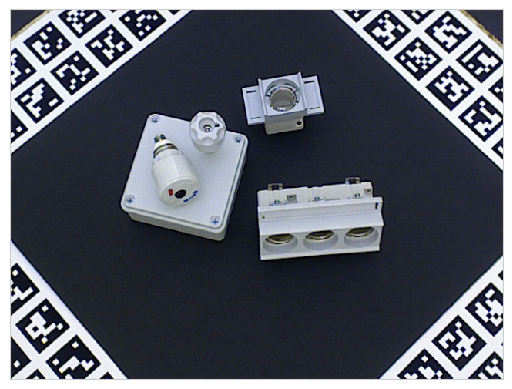

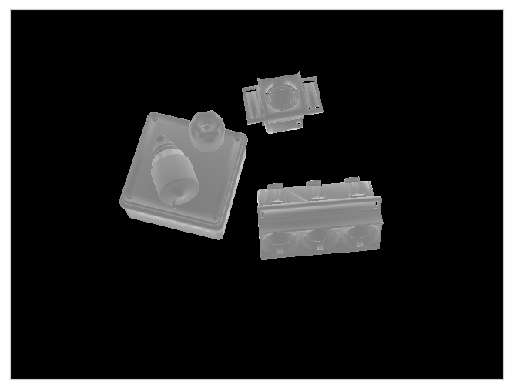

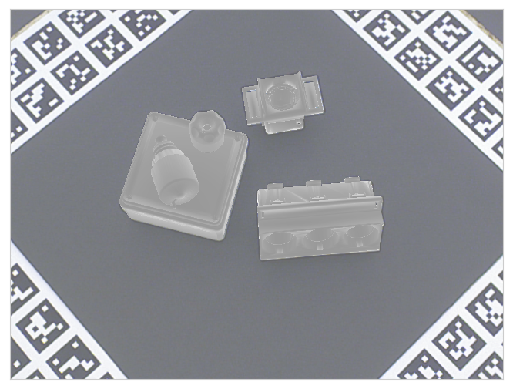

In [25]:
def disp_predictions(scene_ds, predictions):
    renderer = BulletSceneRenderer(urdf_ds_name)

    # figures = make_singleview_prediction_plots(scene_ds, renderer, this_preds)
    figures = None
    detections = None
    resolution = (640, 480)
    if True:
        plotter = Plotter()

        # restore causes used to filter the predictions
        scene_id, view_id = np.unique(predictions.infos['scene_id']).item(), np.unique(predictions.infos['view_id']).item()

        scene_ds_index = scene_ds.frame_index
        scene_ds_index['ds_idx'] = np.arange(len(scene_ds_index))
        scene_ds_index = scene_ds_index.set_index(['scene_id', 'view_id'])
        idx = scene_ds_index.loc[(scene_id, view_id), 'ds_idx']

        augmentation = CropResizeToAspectAugmentation(resize=resolution)
        scene_ds = AugmentationWrapper(scene_ds, augmentation)
        rgb_input, mask, state = scene_ds[idx]

        figures = dict()
        figures['input_im'] = plotter.plot_image(rgb_input)

        if detections is not None:
            fig_dets = plotter.plot_image(rgb_input)
            fig_dets = plotter.plot_maskrcnn_bboxes(fig_dets, detections)
            figures['detections'] = fig_dets

        pred = predictions
        renderer = renderer
        camera = state['camera']
        # pred_rendered = render_prediction_wrt_camera(renderer, predictions, camera=state['camera'])
        # render_predictions_with_respect_to_camera
        pred_rendered = []
        if True:
            pred = pred.cpu()
            camera.update(TWC=np.eye(4))

            list_objects = []
            for n in range(len(pred)):
                row = pred.infos.iloc[n]
                obj = dict(
                    name=row.label,
                    color=(1, 1, 1, 1),
                    TWO=pred.poses[n].numpy(),
                )
                list_objects.append(obj)
            # looks like this place is not required for measuring distances
            pred_rendered = renderer.render_scene(list_objects, [camera])[0]['rgb']
        figures['pred_rendered'] = plotter.plot_image(pred_rendered)
        figures['pred_overlay'] = plotter.plot_overlay(rgb_input, pred_rendered)
        #return figures

    renderer.disconnect()
    print("Predictions:")
    print(predictions)

    # show(figures['input_im'])
    # show(figures['pred_overlay'])

    return figures


print(f"LocalDataDir = {LOCAL_DATA_DIR}")
result_id = 'tless-siso-n_views=1--684390594'
ds_name, urdf_ds_name = 'tless.primesense.test', 'tless.cad'
pred_key = 'pix2pose_detections/refiner/iteration=4' # we have 4 iterations available

# result_id = 'ycbv-n_views=1--5154971130'
# ds_name, urdf_ds_name = 'ycbv.test.keyframes', 'ycbv'
# pred_key = 'posecnn_init/refiner/iteration=2'

results = LOCAL_DATA_DIR / 'results' / result_id / 'results.pth.tar'
scene_ds = make_scene_dataset(ds_name)
results = torch.load(results)['predictions']

print(results.keys())

print("Available scenes for dataset:")
print(results[pred_key].infos.loc[:, ['scene_id', 'view_id']].groupby('scene_id').first())

predictions = results[pred_key]

scene_id = 5
view_id = 27
this_pred = filter_predictions(predictions, scene_id, view_id)

# figures = disp_predictions(scene_ds, this_pred)

figures = disp_predictions(scene_ds, this_pred)

# plt.imshow(in_im)

show_matplot(get_np_image(figures["input_im"]))
show_matplot(get_np_image(figures["pred_rendered"]))
show_matplot(get_np_image(figures["pred_overlay"]))